# Predict Bike Sharing Demand with AutoGluon Template

## Project: Predict Bike Sharing Demand with AutoGluon
This notebook is a template with each step that you need to complete for the project.

Please fill in your code where there are explicit `?` markers in the notebook. You are welcome to add more cells and code as you see fit.

Once you have completed all the code implementations, please export your notebook as a HTML file so the reviews can view your code. Make sure you have all outputs correctly outputted.

`File-> Export Notebook As... -> Export Notebook as HTML`

There is a writeup to complete as well after all code implememtation is done. Please answer all questions and attach the necessary tables and charts. You can complete the writeup in either markdown or PDF.

Completing the code template and writeup template will cover all of the rubric points for this project.

The rubric contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this notebook and also discuss the results in the writeup file.

In [4]:
import pandas as pd
from autogluon.tabular import TabularPredictor
import pickle

In [5]:
def save_data(file: object, filepath: str) -> None:
    """Pickle a file to the filepath specified."""
    with open(filepath, 'wb') as f:
        pickle.dump(file, f)
        
def load_data(filepath: str) -> object:
    """Read a pickle file from the filepath specified."""
    with open(filepath, 'rb') as f:
        return pickle.load(f)

def get_leaderboard(predictor: object, df: pd.DataFrame) -> pd.DataFrame:
    """Get leaderboard from a predictor with extra_info = True."""
    return predictor.leaderboard(df, extra_info=True, silent=True)

In [ ]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o bike-sharing-demand.zip

|field|description|
|:--- |:--- |
|datetime|hourly date + timestamp  
|season| 1 = spring, 2 = summer, 3 = fall, 4 = winter 
|holiday|whether the day is considered a holiday
|workingday|whether the day is neither a weekend nor holiday
|weather||
|1|Clear, Few clouds, Partly cloudy, Partly cloudy 
|2|Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
|3|Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
|4|Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
|temp|temperature in Celsius
|atemp|"feels like" temperature in Celsius
|humidity|relative humidity
|windspeed|wind speed
|casual|number of non-registered user rentals initiated
|registered|number of registered user rentals initiated
|count|number of total rentals

In [6]:
# Read in data and parse datetimes
train = pd.read_csv("./data/train.csv", parse_dates=['datetime'])
test = pd.read_csv("./data/test.csv", parse_dates=['datetime'])
submission = pd.read_csv("./data/sampleSubmission.csv", parse_dates=['datetime'])

In [7]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [9]:
# Simple output of the train dataset to view some of the min/max/variation of the dataset features.
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [10]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [11]:
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


## Step 3: Train a model using AutoGluon’s Tabular Prediction

Requirements:
* We are prediting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset. 
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [7]:
predictor = TabularPredictor(
    label='count', 
    problem_type="regression", 
    eval_metric="root_mean_squared_error", 
    path='./data/run_1'
).fit(
    train_data = train.drop(
    labels=['casual', 'registered'], axis=1),
    time_limit=600,
    presets="best_quality",
)

Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "./data/run_1/"
AutoGluon Version:  0.3.1
Train Data Rows:    10886
Train Data Columns: 9
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    12650.63 MB
	Train Data (Original)  Memory Usage: 0.78 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 2 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting DatetimeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dt

[1000]	train_set's rmse: 123.806	valid_set's rmse: 134.369
[2000]	train_set's rmse: 117.412	valid_set's rmse: 133.705


/home/azathoth/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 123.42	valid_set's rmse: 141.5


/home/azathoth/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 125.097	valid_set's rmse: 128.797
[2000]	train_set's rmse: 119.003	valid_set's rmse: 127.909
[3000]	train_set's rmse: 114.63	valid_set's rmse: 127.431
[4000]	train_set's rmse: 111.295	valid_set's rmse: 126.943
[5000]	train_set's rmse: 108.576	valid_set's rmse: 126.844
[6000]	train_set's rmse: 106.085	valid_set's rmse: 126.71


/home/azathoth/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 124.131	valid_set's rmse: 138.303
[2000]	train_set's rmse: 117.833	valid_set's rmse: 137.535


/home/azathoth/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 124.871	valid_set's rmse: 128.052
[2000]	train_set's rmse: 118.547	valid_set's rmse: 127.003
[3000]	train_set's rmse: 114.124	valid_set's rmse: 126.834
[4000]	train_set's rmse: 110.645	valid_set's rmse: 126.694


/home/azathoth/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 124.654	valid_set's rmse: 135.095
[2000]	train_set's rmse: 118.764	valid_set's rmse: 133.849
[3000]	train_set's rmse: 114.615	valid_set's rmse: 133.509
[4000]	train_set's rmse: 111.249	valid_set's rmse: 133.472
[5000]	train_set's rmse: 108.455	valid_set's rmse: 133.281


/home/azathoth/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 124.01	valid_set's rmse: 139.355
[2000]	train_set's rmse: 117.819	valid_set's rmse: 138.312
[3000]	train_set's rmse: 113.4	valid_set's rmse: 137.886
[4000]	train_set's rmse: 110.032	valid_set's rmse: 137.758


/home/azathoth/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 124.47	valid_set's rmse: 135.412


/home/azathoth/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 124.18	valid_set's rmse: 137.579
[2000]	train_set's rmse: 117.782	valid_set's rmse: 136.664
[3000]	train_set's rmse: 113.447	valid_set's rmse: 136.246
[4000]	train_set's rmse: 109.982	valid_set's rmse: 136.227


/home/azathoth/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 124.641	valid_set's rmse: 132.484


	-134.0883	 = Validation score   (root_mean_squared_error)
	41.8s	 = Training   runtime
	0.51s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 353.9s of the 553.97s of remaining time.
/home/azathoth/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/azathoth/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/azathoth/anaconda3/lib/python3.7/site-packages/lightgbm/engine

[1000]	train_set's rmse: 96.0217	valid_set's rmse: 123.249


/home/azathoth/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 94.7479	valid_set's rmse: 135.635


/home/azathoth/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/azathoth/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 95.3055	valid_set's rmse: 132.087


/home/azathoth/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/azathoth/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 95.1635	valid_set's rmse: 131.521


/home/azathoth/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/azathoth/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
	-132.2864	 = Validation score   (root_mean_squared_error)
	8.94s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 344.5s of the 544.58s of remaining time.
	-118.4567	 = Validation score   (root_mean_squared_error)
	2.

/home/azathoth/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/azathoth/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/azathoth/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

/home/azathoth/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/azathoth/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/azathoth/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

### Create predictions from test dataset

In [8]:
predictions = predictor.predict(test)

0    94.882065
1    86.488220
2    86.488571
3    98.488503
4    98.516037
Name: count, dtype: float32

In [9]:
save_data(predictions, "data/predictions_org.pkl")

Saving file...


In [12]:
predictions = load_data("./data/predictions_org.pkl")

In [13]:
predictions.head()

0    94.882065
1    86.488220
2    86.488571
3    98.488503
4    98.516037
Name: count, dtype: float32

#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [14]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe()

count    6493.000000
mean      207.757721
std       127.554802
min        10.577404
25%       102.848167
50%       192.014648
75%       291.180359
max       643.280640
Name: count, dtype: float64

In [15]:
# How many negative values do we have?
predictions[predictions<0]

Series([], Name: count, dtype: float32)

In [16]:
# Set them to zero
print("I don't see any negative prediction values so I will not set anything to zero.")

I don't see any negative prediction values so I will not set anything to zero.


### Set predictions to submission dataframe, save, and submit

In [37]:
submission["count"] = predictions
submission.to_csv("submission.csv", index=False)

In [40]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

100%|█████████████████████████████████████████| 188k/188k [00:01<00:00, 135kB/s]
Successfully submitted to Bike Sharing Demand

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [41]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName        date                 description           status    publicScore  privateScore  
--------------  -------------------  --------------------  --------  -----------  ------------  
submission.csv  2022-01-01 06:18:09  first raw submission  complete  1.37882      1.37882       


#### Initial score of `1.37882`

## Step 4: Exploratory Data Analysis and Creating an additional feature
* Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.

|field|description|
|:--- |:--- |
|datetime|hourly date + timestamp  
|season| 1 = spring, 2 = summer, 3 = fall, 4 = winter 
|holiday|whether the day is considered a holiday
|workingday|whether the day is neither a weekend nor holiday
|weather||
|1|Clear, Few clouds, Partly cloudy, Partly cloudy 
|2|Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
|3|Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
|4|Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
|temp|temperature in Celsius
|atemp|"feels like" temperature in Celsius
|humidity|relative humidity
|windspeed|wind speed
|casual|number of non-registered user rentals initiated
|registered|number of registered user rentals initiated
|count|number of total rentals

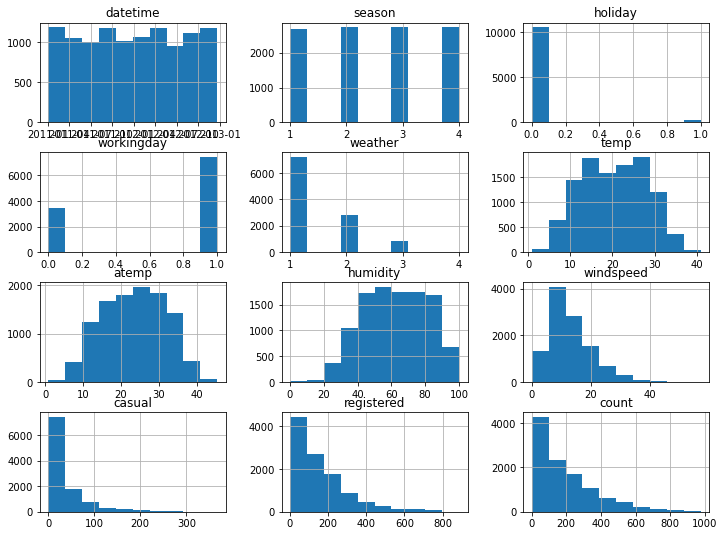

In [15]:
# Create a histogram of all features to show the distribution of each one relative to the data.
# This is part of the exploritory data analysis
train.hist(figsize=(12,9));

In [17]:
# create a new feature
train['month'] = train.datetime.dt.month
train['day'] = train.datetime.dt.day
train['hour'] = train.datetime.dt.hour

test['month'] = test.datetime.dt.month
test['day'] = test.datetime.dt.day
test['hour'] = test.datetime.dt.hour

## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
 12  month       10886 non-null  int64         
 13  day         10886 non-null  int64         
 14  hour        10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(11)
memory usage: 1.2 MB


In [19]:
train["season"] = train["season"].astype('category')
train["weather"] = train["weather"].astype('category')
test["season"] = test["season"].astype('category')
test["weather"] = test["weather"].astype('category')

In [20]:
# View are new feature
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,1,1,4


In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  category      
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  category      
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
 12  month       10886 non-null  int64         
 13  day         10886 non-null  int64         
 14  hour        10886 non-null  int64         
dtypes: category(2), datetime64[ns](1), float64(3), int64(9)
memory usage: 

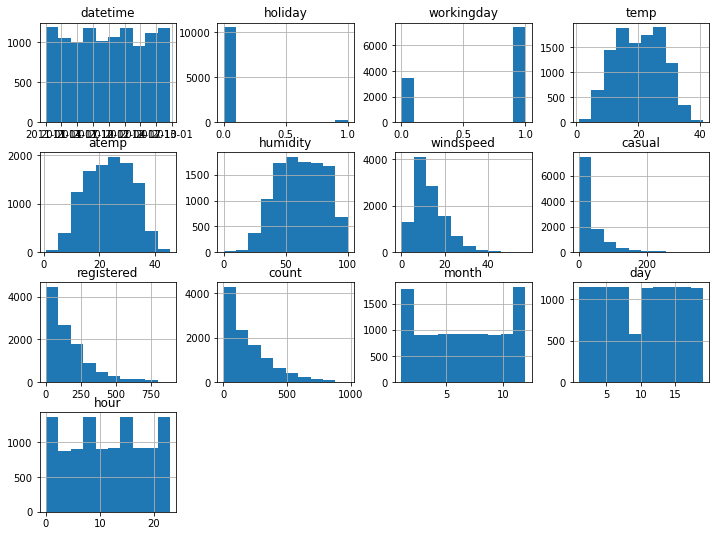

In [34]:
# View histogram of all features again now with the hour feature
train.hist(figsize=(12,9));

## Step 5: Rerun the model with the same settings as before, just with more features

In [15]:
predictor_new_features = TabularPredictor(
    label='count', 
    problem_type="regression", 
    eval_metric="root_mean_squared_error", 
    path='./data/run_2'
).fit(
    train_data = train.drop(labels=['casual', 'registered'], axis=1),
    time_limit=600,
    presets="best_quality",
)

Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "./data/run_2/"
AutoGluon Version:  0.3.1
Train Data Rows:    10886
Train Data Columns: 12
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11917.48 MB
	Train Data (Original)  Memory Usage: 0.89 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 2 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting DatetimeFeatureGenerator...
	Stage 4 Generators:
		Fitt

[1000]	train_set's rmse: 30.5878	valid_set's rmse: 37.5945
[2000]	train_set's rmse: 25.793	valid_set's rmse: 36.0817
[3000]	train_set's rmse: 23.0687	valid_set's rmse: 35.6592
[4000]	train_set's rmse: 21.0911	valid_set's rmse: 35.6075
[5000]	train_set's rmse: 19.5585	valid_set's rmse: 35.5693


/home/azathoth/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 30.8203	valid_set's rmse: 41.4695
[2000]	train_set's rmse: 25.879	valid_set's rmse: 39.2637
[3000]	train_set's rmse: 23.1935	valid_set's rmse: 38.4962
[4000]	train_set's rmse: 21.2613	valid_set's rmse: 38.1806
[5000]	train_set's rmse: 19.746	valid_set's rmse: 37.8942
[6000]	train_set's rmse: 18.4848	valid_set's rmse: 37.6916
[7000]	train_set's rmse: 17.4389	valid_set's rmse: 37.5691
[8000]	train_set's rmse: 16.521	valid_set's rmse: 37.545
[9000]	train_set's rmse: 15.6977	valid_set's rmse: 37.525
[10000]	train_set's rmse: 14.9389	valid_set's rmse: 37.4721


/home/azathoth/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 31.3224	valid_set's rmse: 35.7764
[2000]	train_set's rmse: 26.1498	valid_set's rmse: 34.4519
[3000]	train_set's rmse: 23.3589	valid_set's rmse: 34.3154


/home/azathoth/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 30.9221	valid_set's rmse: 41.3108
[2000]	train_set's rmse: 25.6944	valid_set's rmse: 39.3914
[3000]	train_set's rmse: 23.0534	valid_set's rmse: 38.7312
[4000]	train_set's rmse: 21.1476	valid_set's rmse: 38.3661
[5000]	train_set's rmse: 19.649	valid_set's rmse: 38.199
[6000]	train_set's rmse: 18.4044	valid_set's rmse: 38
[7000]	train_set's rmse: 17.3808	valid_set's rmse: 37.8712
[8000]	train_set's rmse: 16.4885	valid_set's rmse: 37.8522
[9000]	train_set's rmse: 15.6941	valid_set's rmse: 37.7423
[10000]	train_set's rmse: 14.9852	valid_set's rmse: 37.7145


/home/azathoth/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 30.8176	valid_set's rmse: 38.7373
[2000]	train_set's rmse: 25.7379	valid_set's rmse: 37.1131
[3000]	train_set's rmse: 23.0594	valid_set's rmse: 36.8133
[4000]	train_set's rmse: 21.2012	valid_set's rmse: 36.7912
[5000]	train_set's rmse: 19.7067	valid_set's rmse: 36.7527


/home/azathoth/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 30.5275	valid_set's rmse: 41.6176
[2000]	train_set's rmse: 25.6587	valid_set's rmse: 40.7136
[3000]	train_set's rmse: 22.9809	valid_set's rmse: 40.4715
[4000]	train_set's rmse: 21.0804	valid_set's rmse: 40.4018


/home/azathoth/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 31.2445	valid_set's rmse: 38.1974
[2000]	train_set's rmse: 26.1596	valid_set's rmse: 35.3081
[3000]	train_set's rmse: 23.4646	valid_set's rmse: 34.5886
[4000]	train_set's rmse: 21.5012	valid_set's rmse: 34.2072
[5000]	train_set's rmse: 19.9575	valid_set's rmse: 34.0771
[6000]	train_set's rmse: 18.6741	valid_set's rmse: 34.0497
[7000]	train_set's rmse: 17.5938	valid_set's rmse: 34.0622


/home/azathoth/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 30.9465	valid_set's rmse: 39.2936
[2000]	train_set's rmse: 25.9673	valid_set's rmse: 37.9164
[3000]	train_set's rmse: 23.2424	valid_set's rmse: 37.554
[4000]	train_set's rmse: 21.2951	valid_set's rmse: 37.3552
[5000]	train_set's rmse: 19.7329	valid_set's rmse: 37.2682
[6000]	train_set's rmse: 18.4805	valid_set's rmse: 37.2057
[7000]	train_set's rmse: 17.4446	valid_set's rmse: 37.246


/home/azathoth/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 30.5914	valid_set's rmse: 41.1349
[2000]	train_set's rmse: 25.7442	valid_set's rmse: 40.1602
[3000]	train_set's rmse: 23.0758	valid_set's rmse: 39.928
[4000]	train_set's rmse: 21.1858	valid_set's rmse: 39.8469
[5000]	train_set's rmse: 19.6919	valid_set's rmse: 39.8308


/home/azathoth/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 31.2019	valid_set's rmse: 37.3663
[2000]	train_set's rmse: 26.1664	valid_set's rmse: 35.4792
[3000]	train_set's rmse: 23.4247	valid_set's rmse: 34.9177
[4000]	train_set's rmse: 21.516	valid_set's rmse: 34.6833
[5000]	train_set's rmse: 20.0336	valid_set's rmse: 34.5276
[6000]	train_set's rmse: 18.783	valid_set's rmse: 34.4199
[7000]	train_set's rmse: 17.7029	valid_set's rmse: 34.336
[8000]	train_set's rmse: 16.7846	valid_set's rmse: 34.364
[9000]	train_set's rmse: 15.9423	valid_set's rmse: 34.3475
[10000]	train_set's rmse: 15.2156	valid_set's rmse: 34.3716


	-36.7983	 = Validation score   (root_mean_squared_error)
	107.97s	 = Training   runtime
	1.62s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 285.83s of the 485.91s of remaining time.
/home/azathoth/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 21.1363	valid_set's rmse: 35.5572
[2000]	train_set's rmse: 15.5114	valid_set's rmse: 35.4473


/home/azathoth/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 21.0431	valid_set's rmse: 36.9373
[2000]	train_set's rmse: 15.5393	valid_set's rmse: 36.1173
[3000]	train_set's rmse: 12.204	valid_set's rmse: 35.918
[4000]	train_set's rmse: 9.99922	valid_set's rmse: 35.8485


/home/azathoth/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 21.4766	valid_set's rmse: 32.789


/home/azathoth/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 21.4591	valid_set's rmse: 38.1004
[2000]	train_set's rmse: 15.6967	valid_set's rmse: 37.1149
[3000]	train_set's rmse: 12.2044	valid_set's rmse: 36.7233
[4000]	train_set's rmse: 9.95476	valid_set's rmse: 36.6799


/home/azathoth/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 21.3995	valid_set's rmse: 37.384


/home/azathoth/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/azathoth/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 21.6619	valid_set's rmse: 35.9544


/home/azathoth/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 20.9449	valid_set's rmse: 35.7483
[2000]	train_set's rmse: 15.4023	valid_set's rmse: 35.1407


/home/azathoth/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/azathoth/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 21.3287	valid_set's rmse: 36.3231
[2000]	train_set's rmse: 15.6319	valid_set's rmse: 35.6071


	-36.5792	 = Validation score   (root_mean_squared_error)
	33.36s	 = Training   runtime
	0.22s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 251.44s of the 451.51s of remaining time.
	-41.3164	 = Validation score   (root_mean_squared_error)
	3.69s	 = Training   runtime
	0.36s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 247.13s of the 447.21s of remaining time.
	-36.3888	 = Validation score   (root_mean_squared_error)
	171.88s	 = Training   runtime
	0.07s	 = Validation runtime
Fitting model: ExtraTreesMSE_BAG_L1 ... Training model for up to 75.06s of the 275.13s of remaining time.
	-40.9062	 = Validation score   (root_mean_squared_error)
	1.19s	 = Training   runtime
	0.31s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ... Training model for up to 73.2s of the 273.27s of remaining time.
		Import fastai failed. A quick tip is to install via `pip install fastai==2.*`. If you are using Mac OSX, pl

/home/azathoth/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/azathoth/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/azathoth/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

	Ran out of time, early stopping on iteration 83. Best iteration is:
	[83]	train_set's rmse: 27.9746	valid_set's rmse: 39.5728
/home/azathoth/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
	Ran out of time, early stopping on iteration 95. Best iteration is:
	[95]	train_set's rmse: 25.3173	valid_set's rmse: 36.7334
/home/azathoth/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
	Ran out of time, early stopping

In [36]:
predictor_new_features.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L2  -34.546557       2.478926  372.633913                0.000289           0.224187            2       True         11
1      WeightedEnsemble_L3  -34.659072       5.293322  485.478093                0.000294           0.225147            3       True         20
2     ExtraTreesMSE_BAG_L2  -35.090333       3.301686  374.450908                0.238319           0.647531            2       True         16
3          LightGBM_BAG_L2  -35.105219       3.101505  376.187793                0.038138           2.384415            2       True         13
4          CatBoost_BAG_L2  -35.165703       3.095154  379.183632                0.031787           5.380255            2       True         15
5           XGBoost_BAG_L2  -35.194725       3.124798  376.858511         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'NeuralNetMXNet_BAG_L1': 'StackerEnsembleModel_TabularNeuralNet',
  'LightGBMLarge_BAG_L1': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'XGBoost_BAG_L2': 'StackerEnsembleModel_XGBoost',
  'NeuralNetMXNet_BAG_L2': 'StackerEnsembleModel_TabularNeuralNet',
  'Ligh

In [16]:
predictions = predictor_new_features.predict(test)
predictions.head()

0    13.327668
1     0.027438
2    -1.727285
3     0.442032
4     0.528605
Name: count, dtype: float32

In [17]:
predictions[predictions<0]

2       -1.727285
25      -1.397056
27     -14.203905
52      -4.413974
53     -14.950122
          ...    
6235    -7.403056
6260    -4.098753
6283    -3.240298
6450    -3.381070
6451    -8.066739
Name: count, Length: 133, dtype: float32

In [18]:
# Remember to set all negative values to zero
predictions.loc[predictions<0] = 0

In [19]:
save_data(predictions, "./data/predictions_new.pkl")

Saving file...


In [53]:
submission_new_features = pd.read_csv("./data/sampleSubmission.csv", parse_dates=['datetime'])

In [54]:
# Same submitting predictions
submission_new_features["count"] = predictions
submission_new_features.to_csv("./data/submission_new_features.csv", index=False)

In [60]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

100%|████████████████████████████████████████| 188k/188k [00:03<00:00, 58.1kB/s]
Successfully submitted to Bike Sharing Demand

In [61]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description           status    publicScore  privateScore  
---------------------------  -------------------  --------------------  --------  -----------  ------------  
submission_new_features.csv  2022-01-02 06:27:59  new features          complete  0.51509      0.51509       
submission.csv               2022-01-01 06:18:09  first raw submission  complete  1.37882      1.37882       


#### New Score of `0.51509`

In [15]:
predictor.feature_importance(train)

,importance,stddev,p_value,n,p99_high,p99_low
hour,178.409528,4.545527,0.000108,3,204.455901,152.363154
workingday,73.299919,2.980422,0.000275,3,90.378067,56.221771
datetime,69.861382,5.124521,0.000894,3,99.225456,40.497308
temp,18.255489,2.178263,0.002356,3,30.737179,5.773800
humidity,15.105299,1.351629,0.001329,3,22.850286,7.360312
weather,10.473149,1.316812,0.002614,3,18.018626,2.927672
atemp,8.403531,1.710810,0.006768,3,18.206660,-1.399598
day,1.840270,0.259345,0.003278,3,3.326343,0.354197
holiday,1.503480,0.233579,0.003975,3,2.841915,0.165045
windspeed,1.037308,0.389860,0.022000,3,3.271248,-1.196631


In [18]:
y_pred = predictor.predict(test)
y_pred = pd.DataFrame(y_pred,columns=['count'])

## Step 6: Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

In [158]:
# These were found in the autogluon docs and provide a base for hyperparameter tuning.
# I used these values due to not having much luck finding better ones.
import autogluon.core as ag

nn_options = {  # specifies non-default hyperparameter values for neural network models
    'num_epochs': 10,  # number of training epochs (controls training time of NN models)
    'learning_rate': ag.space.Real(1e-4, 1e-2, default=5e-4, log=True),  # learning rate used in training (real-valued hyperparameter searched on log-scale)
    'activation': ag.space.Categorical('relu', 'softrelu', 'tanh'),  # activation function used in NN (categorical hyperparameter, default = first entry)
    'layers': ag.space.Categorical([100], [1000], [200, 100], [300, 200, 100]),  # each choice for categorical hyperparameter 'layers' corresponds to list of sizes for each NN layer to use
    'dropout_prob': ag.space.Real(0.0, 0.5, default=0.1),  # dropout probability (real-valued hyperparameter)
}

gbm_options = {  # specifies non-default hyperparameter values for lightGBM gradient boosted trees
    'num_boost_round': 100,  # number of boosting rounds (controls training time of GBM models)
    'num_leaves': ag.space.Int(lower=26, upper=66, default=36),  # number of leaves in trees (integer hyperparameter)
}

hyperparameters = {  # hyperparameters of each model type
                   'GBM': gbm_options,
                   'NN': nn_options,  # NOTE: comment this line out if you get errors on Mac OSX
}  # When these keys are missing from hyperparameters dict, no models of that type are trained

num_trials = 5  # try at most 5 different hyperparameter configurations for each type of model
search_strategy = 'auto'  # to tune hyperparameters using Bayesian optimization routine with a local scheduler

hyperparameter_tune_kwargs = {  # HPO is not performed unless hyperparameter_tune_kwargs is specified
    'num_trials': num_trials,
    'scheduler' : 'local',
    'searcher': search_strategy,
}

In [ ]:
predictor_new_hpo = TabularPredictor(
    label="count", 
    eval_metric="root_mean_squared_error", 
    learner_kwargs={'ignored_columns': ['casual', 'registered']}
).fit(
    train, 
    presets='best_quality', 
    time_limit=time_limit,
    hyperparameters=hyperparameters, 
    hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,
)

In [19]:
predictor_new_hpo.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                       model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0        WeightedEnsemble_L3  -41.042591      18.993819  428.102552                0.000297           0.251812            3       True         22
1         LightGBM_BAG_L2/T2  -41.139724      13.541334  304.143487                0.095257           3.314752            2       True         14
2         LightGBM_BAG_L2/T0  -41.140622      13.547064  304.185985                0.100987           3.357250            2       True         12
3         LightGBM_BAG_L2/T3  -41.177679      13.541198  304.101974                0.095121           3.273238            2       True         15
4         LightGBM_BAG_L2/T1  -41.216469      13.541422  304.194988                0.095345           3.366252            2       True         13
5         LightGBM_BAG_L1/T3  -42.293120       0.124615    3.6

{'model_types': {'LightGBM_BAG_L1/T0': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T3': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T4': 'StackerEnsembleModel_LGB',
  'NeuralNetMXNet_BAG_L1/T0': 'StackerEnsembleModel_TabularNeuralNet',
  'NeuralNetMXNet_BAG_L1/T1': 'StackerEnsembleModel_TabularNeuralNet',
  'NeuralNetMXNet_BAG_L1/T2': 'StackerEnsembleModel_TabularNeuralNet',
  'NeuralNetMXNet_BAG_L1/T3': 'StackerEnsembleModel_TabularNeuralNet',
  'NeuralNetMXNet_BAG_L1/T4': 'StackerEnsembleModel_TabularNeuralNet',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBM_BAG_L2/T0': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2/T1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2/T2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2/T3': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2/T4': 'StackerEnsembleModel_LGB',
  'NeuralNetMXNet_BAG_L2/T0': 'StackerEnsembleModel_TabularN

In [192]:
predictions = predictor_new_hpo.predict(test)
predictions.head()

0    13.255105
1     4.656514
2     2.026344
3     2.899639
4     2.899639
Name: count, dtype: float32

In [193]:
save_data(predictions, 'data/predictions_newhp.pkl')

In [87]:
save_data(leaderboard_pred, "./data/leaderboard_pred.pkl")

Saving file...


In [29]:
predictions[predictions<0] = 0

In [204]:
submission = pd.read_csv("./data/sampleSubmission.csv", parse_dates=['datetime'])

In [33]:
submission_new_hpo = pd.read_csv("./data/sampleSubmission.csv", parse_dates=['datetime'])

In [34]:
# Same submitting predictions
submission_new_hpo["count"] = predictions
submission_new_hpo.to_csv("submission_new_hpo.csv", index=False)

In [35]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters"

100%|█████████████████████████████████████████| 188k/188k [00:01<00:00, 102kB/s]
Successfully submitted to Bike Sharing Demand

In [36]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_hpo.csv       2022-01-04 03:20:46  new features with hyperparameters  complete  0.50827      0.50827       
submission_new_features.csv  2022-01-02 06:27:59  new features                       complete  0.51509      0.51509       
submission.csv               2022-01-01 06:18:09  first raw submission               complete  1.37882      1.37882       


#### New Score of `0.50827`

# Analyze Data

In [22]:
predictor = TabularPredictor.load('./data/run_1')
predictor_new = TabularPredictor.load('./data/run_2')
predictor_newhp = TabularPredictor.load('./data/run_3')

leaderboard_pred = load_data("./data/leaderboard_pred.pkl")
leaderboard_pred_new = load_data("./data/leaderboard_pred_new.pkl")
leaderboard_pred_newhp = load_data("./data/leaderboard_pred_newhp.pkl")

preds = load_data('./data/predictions_org.pkl')
preds_new = load_data('./data/predictions_new.pkl')
preds_newhp = load_data('./data/predictions_newhp.pkl')

In [23]:
train = pd.read_csv("./data/train.csv", parse_dates=['datetime'])
test = pd.read_csv("./data/test.csv", parse_dates=['datetime'])

In [ ]:
# predictor.evaluate(train)

In [24]:
train['month'] = train.datetime.dt.month
train['day'] = train.datetime.dt.day
train['hour'] = train.datetime.dt.hour

test['month'] = test.datetime.dt.month
test['day'] = test.datetime.dt.day
test['hour'] = test.datetime.dt.hour

train["season"] = train["season"].astype('category')
train["weather"] = train["weather"].astype('category')
test["season"] = test["season"].astype('category')
test["weather"] = test["weather"].astype('category')

In [ ]:
leaderboard_pred

In [ ]:
leaderboard_pred_new

In [ ]:
leaderboard_pred_newhp

In [28]:
print(f"Top Model, original run: {leaderboard_pred.iloc[0]['model']}")
print(f"Top Model, new run:      {leaderboard_pred_new.iloc[0]['model']}")
print(f"Top Model, newhp run:    {leaderboard_pred_newhp.iloc[0]['model']}")
print("-"*25, "Train Score", "-"*25)
print(f"Top Model, original score: {leaderboard_pred.iloc[0]['score_test']}")
print(f"Top Model, new score:      {leaderboard_pred_new.iloc[0]['score_test']}")
print(f"Top Model, newhp score:    {leaderboard_pred_newhp.iloc[0]['score_test']}")
print("-"*26, "Val Score", "-"*26)
print(f"Top Model, original score: {leaderboard_pred.iloc[0]['score_val']}")
print(f"Top Model, new score:      {leaderboard_pred_new.iloc[0]['score_val']}")
print(f"Top Model, newhp score:    {leaderboard_pred_newhp.iloc[0]['score_val']}")

Top Model, original run: RandomForestMSE_BAG_L1
Top Model, new run:      KNeighborsDist_BAG_L1
Top Model, newhp run:    LightGBM_BAG_L2/T2
------------------------- Train Score -------------------------
Top Model, original score: -43.6340108824743
Top Model, new score:      -1.7149685218828519
Top Model, newhp score:    -33.44115290332426
-------------------------- Val Score --------------------------
Top Model, original score: -118.45666016795751
Top Model, new score:      -119.37260178212154
Top Model, newhp score:    -41.331075782404724


In [ ]:
# predictor_new.evaluate(train)

# predictor_newhp.evaluate(train)

## Step 7: Write a Report
### Refer to the markdown file for the full report
### Creating plots and table for report

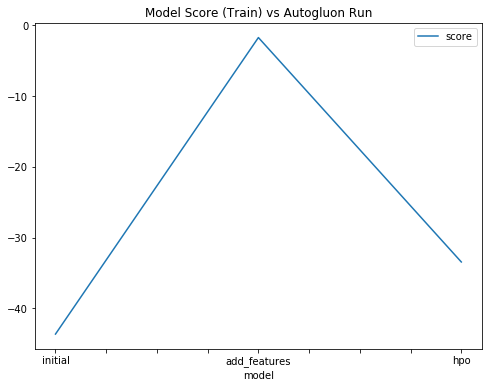

In [34]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
df = pd.DataFrame(
    {
        "model": [
            "initial", 
            "add_features", 
            "hpo"
        ],
        "score": [
            leaderboard_pred.iloc[0]['score_test'], 
            leaderboard_pred_new.iloc[0]['score_test'], 
            leaderboard_pred_newhp.iloc[0]['score_test']
        ]
    }
)

fig = df.plot(
    x="model",
    y="score",
    figsize=(8, 6),
    title="Model Score (Train) vs Autogluon Run"
).get_figure()

fig.savefig('./img/model_train_score.png')

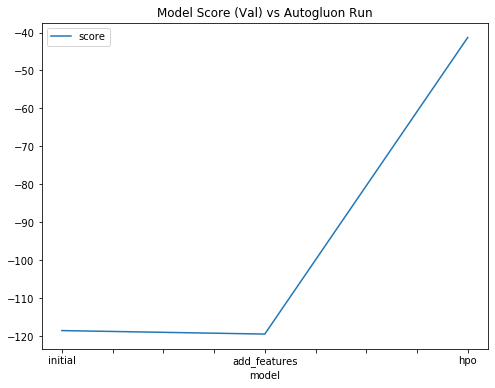

In [31]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
df = pd.DataFrame(
    {
        "model": [
            "initial", 
            "add_features", 
            "hpo"
        ],
        "score": [
            leaderboard_pred.iloc[0]['score_val'], 
            leaderboard_pred_new.iloc[0]['score_val'], 
            leaderboard_pred_newhp.iloc[0]['score_val']
        ]
    }
)

fig = df.plot(
    x="model",
    y="score",
    figsize=(8, 6),
    title="Model Score (Val) vs Autogluon Run"
).get_figure()

fig.savefig('./img/model_val_score.png')

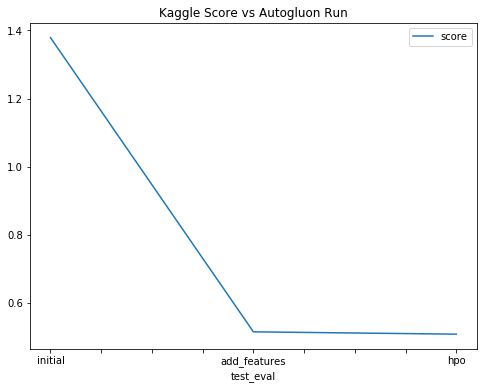

In [33]:
# Take the 3 kaggle scores and creating a line plot to show improvement
df = pd.DataFrame(
    {
        "test_eval": [
            "initial", 
            "add_features", 
            "hpo"
        ],
        "score": [
            1.37882, 
            0.51509, 
            0.50827
        ]
    }
)

fig = df.plot(
    x="test_eval", 
    y="score", 
    figsize=(8, 6),
    title="Kaggle Score vs Autogluon Run"
).get_figure()

fig.savefig('./img/model_test_score.png')

### Hyperparameter table

|model|hpo1|hpo2|hpo3|score|
|--|--|--|--|--|
|initial|default values|default values|default values|1.37882|
|add_features|default values|default values|default values|0.51509|
|hpo|NN 'num_epochs': 10, 'learning_rate': ag.space.Real(1e-4, 1e-2, default=5e-4, log=True), 'activation': ag.space.Categorical('relu', 'softrelu', 'tanh'), 'layers': ag.space.Categorical([100], [1000], [200, 100], [300, 200, 100]), 'dropout_prob': ag.space.Real(0.0, 0.5, default=0.1)|GBM 'num_boost_round': 100, 'num_leaves': ag.space.Int(lower=26, upper=66, default=36)|default vals|0.50827|